# DS405 Machine Learning Applications in Business and Economics Mini-Project
---

<font color="red">TBD: 
- What features to use? 
    - Construct new ones? 
    - Simply leave out all non-numeric features? 
    - Delivery-Delay might be interesting
    - Delivery Delay

</font>


## Introduction

In the realm of e-commerce, a common observation is that a significant proportion of customers engage in a single transaction and then cease further purchases. This phenomenon can be attributed to a multitude of factors. To mitigate this, e-commerce platforms employ a variety of strategies aimed at fostering customer loyalty. One such strategy involves the distribution of discount vouchers subsequent to the initial purchase, with the goal of incentivizing repeat transactions. However, indiscriminate distribution of these vouchers may not be an optimal strategy. This is because a segment of customers might have engaged in repeat purchases even in the absence of such incentives. Consequently, the redemption of these vouchers by such customers translates into a reduction in the retailer’s profit. Empirical analyses conducted by the media retailer have demonstrated that for 10% of non-buyers, the voucher instigates a purchase with an average order value of €20. Thus, if a voucher is dispatched to a customer who would not have actually made another purchase, the revenue increases by an average of €1.5. On the other hand, sending a voucher to a customer who would have made a purchase anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues. Therefore, it is crucial to devise a more targeted approach for the distribution of these vouchers.

## Task 

The task at hand involves constructing a predictive model that leverages various features associated with a customer’s initial order. The objective is to determine whether a €5.00 voucher should be issued to a specific customer. Detailed descriptions of these features can be found in the data dictionary.pdf file.
The model should be designed to predict if a customer will place a subsequent order within a 90-day period following their initial purchase. This information is represented by the target90 variable in the dataset. The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.


---

In [255]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Binary dependent variable
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from datetime import datetime
import time

### Step 1: Reading in and getting an overview of the data

In [256]:
# Separator is ;
train = pd.read_csv("train.csv", sep = ";")
# Get number of rows and columns
print(train.shape)

# Get overview via .describe()
# Dataset is wide, print all rows and only first 15 columns
train.describe().iloc[:,0:15]

(32428, 38)


C:\Users\benny\AppData\Local\Temp\ipykernel_15772\3868431855.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", sep = ";")


,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.0
mean,33389.298569,0.541569,0.006969,7.517115,0.169483,1.646910,1.000987,0.201955,48.752282,0.162020,2.934378,2.019551,0.004564,0.414642,0.0
std,19148.090449,0.657044,0.083192,3.683945,0.375184,0.825981,1.092677,0.401465,24.361425,0.368475,1.319270,1.726046,0.067404,0.492668,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,16802.750000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0
50%,33552.500000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000,0.000000,47.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0
75%,50034.250000,1.000000,0.000000,11.000000,0.000000,2.000000,2.000000,0.000000,66.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0
max,66251.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,50.000000,1.000000,1.000000,0.0


In [257]:
# Second half of the columns
# Dataset is wide, print all rows and only remaining columns
train.describe().iloc[:,15:]

,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000
mean,0.150611,637.920809,0.059979,0.061613,0.068860,0.902122,0.404342,0.276644,0.018903,0.047027,0.180986,0.027908,0.023128,0.000185,0.164981,0.092883,0.186598
std,0.357674,724.358131,0.388740,0.306833,0.474444,1.654767,1.410395,1.353981,0.253596,0.434265,0.561751,0.299862,0.401782,0.013601,0.836705,0.610509,0.389594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,494.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,920.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,20076.000000,19.000000,17.000000,19.000000,99.000000,84.000000,90.000000,15.000000,36.000000,14.000000,27.000000,55.000000,1.000000,48.000000,50.000000,1.000000


Every column has a count of 32428 -> No missing values seem to be present. In the case of binary encoded variables, the mean directly reflects a percentage (if multiplied by 100). \
However, due to their datatype, some columns are not present in the .describe()-dataframe. Therefore, to fully detect all missing values, we loop over all columns in the as follows:

In [258]:
# Function to check for NAs in every column
def count_na(df):
    for col in df.columns:          # Loop over all columns
        n_na = df[col].isna().sum() # Count occurrences of missing values
        if n_na > 0:                # Only give column and count if there actually are NAs
            print(col, n_na)        # Print column name and number of NAs

# Apply function
count_na(train)

delivpostcode 31036
advertisingdatacode 25905


We only seem to have missing values in the *delivpostcode* and the *advertisingdatacode* column. \
One possible approach of fixing the issue in the *delivpostcode* column would be to simply impute the values of the *invoicepostcode* column. However, these values do not necessarily have to match. \
For the *advertisingdatacode* column, we do not have a logical approach of dealing with these rather unique data type and its missing values.  

#### Computing delivery delay

We expect a potential delay in the delivery to have a systematic influence on a customer's re-purchase probability. The longer this delay gets, the less likely an expected re-purchase will become. 

In [259]:
# Convert actual delivery date to datetime
for i in range(len(train)):  
    if train.loc[i, "deliverydatereal"].startswith("0000"):  
        train.loc[i, "deliverydatereal"] = np.nan
    else:
        train.loc[i, "deliverydatereal"] = pd.to_datetime(train.loc[i, "deliverydatereal"])

# Convert promised delivery date to datetime
for i in range(len(train)):
    if train.loc[i, "deliverydatepromised"].startswith("0000"): # disregard missing values
        train.loc[i, "deliverydatepromised"] = np.nan
    else:
        try: # Exception had to be added because some dates were out of bounds (Year 4746)
            train.loc[i, "deliverydatepromised"] = pd.to_datetime(train.loc[i, "deliverydatepromised"])
        except pd.errors.OutOfBoundsDatetime:
            train.loc[i, "deliverydatepromised"] = np.nan

# Compute actual delay in timedelta format
train["delay"] = [0] * len(train)

for i in range(len(train)):
    if pd.notna(train["deliverydatereal"][i]) and pd.notna(train["deliverydatepromised"][i]):
        train.loc[i, "delay"] = train["deliverydatereal"][i] - train["deliverydatepromised"][i]
    else:
        train.loc[i, "delay"] = np.nan

# Get days of delay
for i in range(len(train)):
    if pd.notna(train["delay"][i]):
        train.loc[i, "delay"] = train["delay"][i].days
    else:
        train.loc[i, "delay"] = np.nan

missing_values = train["delay"].isna().sum()
print(f"Number of missing values in Delay column: {missing_values}")  


C:\Users\benny\AppData\Local\Temp\ipykernel_15772\3210224163.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1 days +00:00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[i, "delay"] = train["deliverydatereal"][i] - train["deliverydatepromised"][i]


Number of missing values in train["delay"]: 5478


Unfortunately, only few classifiers can work with NaNs. Since we have over 5000 missing values, different ways of imputing them could have a considerable impact on our model predictions. \
Therefore we disregard the Delivery Delay variable and stick to the original data set. 

In [263]:
disregarded_columns = []
for col in train.columns:
    if col not in train.describe().columns:
        disregarded_columns.append(col)
print(disregarded_columns)

['date', 'datecreated', 'delivpostcode', 'advertisingdatacode', 'deliverydatepromised', 'deliverydatereal', 'delay']


- **Date**: We don't expect the date to have a systematic influence on a customer's re-purchase probability.
- **Datecreated**: We don't expect the date of account creation to have a systematic influence on a customer's re-purchase probability.
- **Delivpostcode**: Too many missing values.
- **Advertisingdatacode**: Too many missing values.
- **Deliverydatepromised**: We don't expect the promised delivery date to have a systematic influence on a customer's re-purchase probability.
- **Deliverydatereal**: We don't expect the actual delivery date to have a systematic influence on a customer's re-purchase probability.
- **Delay**: We did expect the delivery delay to have a systematic influence on a customer's re-purchase probability. However, there are too many missing values present. 
                

---

### First try of estimation with RandomForestClassifier

In [269]:
# Only includes training data for now (handle division by 0)
def evaluate_model(Y_train, Y_train_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(Y_train_pred)): 
        if Y_train[i]==Y_train_pred[i]==1:
           TP += 1
        if Y_train_pred[i]==1 and Y_train[i]!=Y_train_pred[i]:
           FP += 1
        if Y_train[i]==Y_train_pred[i]==0:
           TN += 1
        if Y_train_pred[i]==0 and Y_train[i]!=Y_train_pred[i]:
           FN += 1

    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print results
    print("Accuracy:", accuracy)
    print("Precision (Share of positives correctly specified):", precision) # of all actual 1s, how many did we predict as 1
    print("Sensitivity (Share of actual true values found):", sensitivity) # of all our predictions with 1, how many were actually 1
    print("Specificity (Share of actual false values found):", specificity) # of all our predictions with 0, how many were actually 0
    print(f"TP: {TP}", f"FP: {FP}", f"TN: {TN}", f"FN: {FN}")


In [270]:
# Construct training data set to contain only numeric variables (as listed in .describe())
X_train = train[train.describe().columns].drop(columns = ["target90"])
#X_train = pd.concat([X_train, train["delay"]])
# X_train.columns = X_train.columns.astype(str)
# Construct dependent variable
Y_train = train["target90"]

In [271]:
# Just to check if we can actually estimate the data set
forest = RandomForestClassifier(n_estimators = 20, max_depth = 90, min_samples_split = 2, min_samples_leaf = 1, criterion = "entropy")
forest.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=90, n_estimators=20)

In [272]:
# Get Model predictions
Y_train_pred = forest.predict(X_train)

In [273]:
# Evaluate accuracy of cross-validated model 
evaluate_model(Y_train, Y_train_pred)

Accuracy: 0.9915813494510917
Precision (Share of positives correctly specified): 1.0
Sensitivity (Share of actual true values found): 0.9548834903321765
Specificity (Share of actual false values found): 1.0
TP: 5778 FP: 0 TN: 26377 FN: 273


In [173]:
# Conduct RandomizedSearchCV over input parameters
max_depth = range(30,80) 
min_samples_split = range(10,20)
min_samples_leaf = range(5,20)
n_estimators = range(30,50)
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

forest = RandomForestClassifier()
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs=-1, cv=5,verbose=1, n_iter=500, scoring='accuracy')
forest_cv.fit(X_train,Y_train) # does it automatically use best parameters? 

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(30, 80),
                                        'min_samples_leaf': range(5, 20),
                                        'min_samples_split': range(10, 20),
                                        'n_estimators': range(30, 50)},
                   scoring='accuracy', verbose=1)

In [174]:
# Feature importance
print(forest_cv.best_estimator_.feature_importances_)

[1.69480997e-01 3.14464492e-02 4.50896327e-04 7.60253651e-02
 3.49351192e-02 2.39532421e-02 3.13753015e-02 2.16763156e-02
 1.39650807e-01 1.51143800e-02 4.67293288e-02 4.35568206e-02
 1.55201785e-04 1.33620340e-02 0.00000000e+00 1.87246087e-02
 1.47433093e-01 4.39701631e-02 6.63872485e-03 9.60583342e-03
 3.60795688e-02 2.66937291e-02 1.62388539e-02 5.26453397e-03
 3.92985450e-03 1.15885383e-02 2.51691960e-03 1.90129538e-03
 0.00000000e+00 1.33508036e-02 8.15122143e-03]


In [175]:
# Optimal parameters
forest_cv.best_params_

{'n_estimators': 47,
 'min_samples_split': 18,
 'min_samples_leaf': 9,
 'max_depth': 76}

In [176]:
Y_train_pred_cv = forest_cv.predict(X_train)

In [179]:
evaluate_model(Y_train, Y_train_pred_cv) 

Accuracy: 0.8150135701949174
Precision (Share of positives correctly specified): 0.9636363636363636
Sensitivity (Share of actual true values found): 0.008761778806414284
Specificity (Share of actual false values found): 0.9999241706161137
TP: 53 FP: 2 TN: 26373 FN: 5996


Not really sure what to make of these results yet 

Text(0.5, 1.0, 'Random Forest Regression Feature Importances')

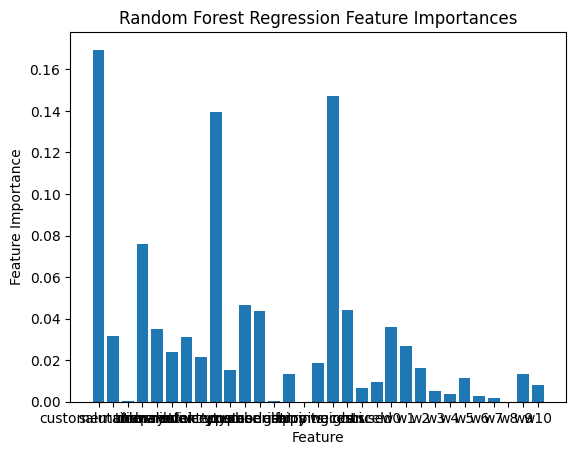

In [178]:
# Plot feature importance
fig = plt.figure()
ax = fig.gca() #get current axis
ax.bar(range(X_train.shape[1]), forest_cv.best_estimator_.feature_importances_)
ax.set_xticks(np.arange(X_train.shape[1]))
ax.set_xticklabels([f'{col}' for col in X_train.columns])
ax.set_xlabel('Feature')
ax.set_ylabel('Feature Importance')
ax.set_title('Random Forest Regression Feature Importances')

# Ugly ass graph but its working 

---

### Ada Boost

In [181]:
ada = AdaBoostClassifier(n_estimators = 1000, learning_rate = 0.8)
ada = ada.fit(X_train, Y_train)

In [183]:
Y_train_pred_ada = ada.predict(X_train)
evaluate_model(Y_train, Y_train_pred_ada)

Accuracy: 0.8147976807303232
Precision (Share of positives correctly specified): 0.6358024691358025
Sensitivity (Share of actual true values found): 0.017027607869069268
Specificity (Share of actual false values found): 0.9977630331753554
TP: 103 FP: 59 TN: 26316 FN: 5946


In [72]:
metrics.confusion_matrix(Y_train, Y_train_pred_ada)

array([[26377,     0],
       [ 6049,     2]], dtype=int64)

In [125]:
sum(Y_train == 0)

26377

In [126]:
sum(Y_train_pred_cv == 0)

32378